# RQ1: ANCOVA with Power Analysis & T-Tests

---



In [ ]:
!pip install pingouin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pingouin import ancova
import seaborn as sns
from scipy import stats
%matplotlib inline 
import statsmodels
from statsmodels.stats.power import TTestPower
from scipy.stats import ttest_ind
pd.options.display.max_columns = None #show all columns in data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Read the file
data = pd.read_csv("/content/drive/MyDrive/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv")
# Gary temp - data = pd.read_csv("/content/drive/MyDrive/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv")

In [ ]:
#Assign 0 to the null values in the columns related to actions at arrest and search reasons
L = ['Actions_at_arrest___Combative__', 'Actions_at_arrest___Assaulted_o', 'Actions_at_arrest___Concealed_i', 'Actions_at_arrest___Resisted__d', 'Actions_at_arrest___Mental_inst', 'SearchReason_CauseInjury', 'SearchReason_AssistEscape', 'SearchReason_PossessWeapons', 'SearchReason_PossessEvidence', 'ItemsFound']
for x in L:
  data[x] = data[x].replace(np.NaN, 0)

In [ ]:
# Calculate the sum of the columns related to actions at arrest and search reasons to form a new column "Event number"
data["Event number"] = data['Actions_at_arrest___Combative__'] + data['Actions_at_arrest___Assaulted_o'] + data['Actions_at_arrest___Concealed_i'] + data['Actions_at_arrest___Resisted__d'] + data['Actions_at_arrest___Mental_inst'] + data['SearchReason_CauseInjury'] + data['SearchReason_AssistEscape'] + data['SearchReason_PossessWeapons'] + data['SearchReason_PossessEvidence'] + data['ItemsFound']

In [ ]:
#Removed all columns except interested ones
data = data.loc[:, data.columns.intersection(['Sex','Event number','PersonID'])]
data.shape

(65276, 3)

In [ ]:
#Delete rows with unclear sex of gender and nan values
data = data.loc[data["Sex"] != "U"]
data = data.dropna(axis = 0)
data.shape

(65267, 3)

In [ ]:
data.head

<bound method NDFrame.head of        PersonID Sex  Event number
0        326622   M           0.0
1        326622   M           0.0
2        326622   M           0.0
3        327535   M           0.0
4        327535   M           0.0
...         ...  ..           ...
65271    316123   F           1.0
65272    307736   M           0.0
65273    324057   F           0.0
65274    331870   M           0.0
65275    310583   M           0.0

[65267 rows x 3 columns]>

In [ ]:
#Calculate the total arrest cases for each arrestee
data2 = data.groupby('PersonID').size().reset_index(name='Arrested number')
data2

,PersonID,Arrested number
0,300000,1
1,300001,1
2,300002,1
3,300003,8
4,300004,1
...,...,...
37339,337342,5
37340,337343,1
37341,337344,1
37342,337345,1


In [ ]:
#Calculate the sums of event numbers for each arrestee
data3 = data.groupby('PersonID')['Event number'].sum().reset_index(name='Total event number')
data = data.drop('Event number', axis=1).drop_duplicates()
data3 = pd.merge(data, data3, on="PersonID")
data3

,PersonID,Sex,Total event number
0,326622,M,0.0
1,327535,M,0.0
2,330778,M,3.0
3,328630,M,0.0
4,312724,M,4.0
...,...,...,...
37376,316123,F,1.0
37377,307736,M,0.0
37378,324057,F,0.0
37379,331870,M,0.0


In [ ]:
#Merge two data frames on PersonID
data = pd.merge(data2, data3, on="PersonID")
data

,PersonID,Arrested number,Sex,Total event number
0,300000,1,M,0.0
1,300001,1,F,0.0
2,300002,1,M,0.0
3,300003,8,M,3.0
4,300004,1,M,0.0
...,...,...,...,...
37376,337342,5,M,1.0
37377,337343,1,M,0.0
37378,337344,1,M,3.0
37379,337345,1,M,0.0


In [ ]:
#Some rows with same Person ID have different gender, which does not make sense. So we remove these rows
data = data.drop_duplicates(subset=['PersonID'], keep = False)
data

,PersonID,Arrested number,Sex,Total event number
0,300000,1,M,0.0
1,300001,1,F,0.0
2,300002,1,M,0.0
3,300003,8,M,3.0
4,300004,1,M,0.0
...,...,...,...,...
37376,337342,5,M,1.0
37377,337343,1,M,0.0
37378,337344,1,M,3.0
37379,337345,1,M,0.0


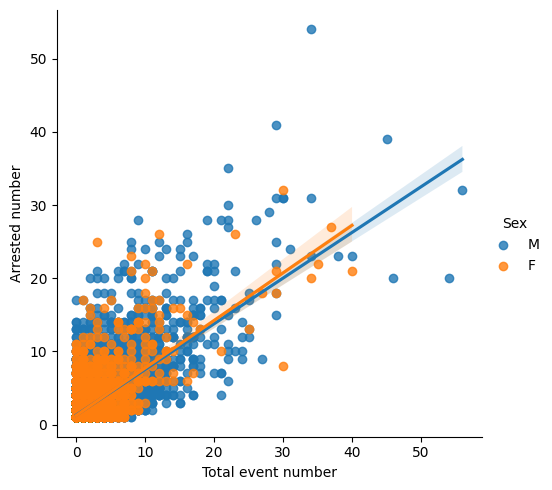

In [ ]:
#Plot Arrest numbers with Event numbers to see if they have a linear relationship
sns.lmplot(data=data, x='Total event number', y='Arrested number', hue='Sex')

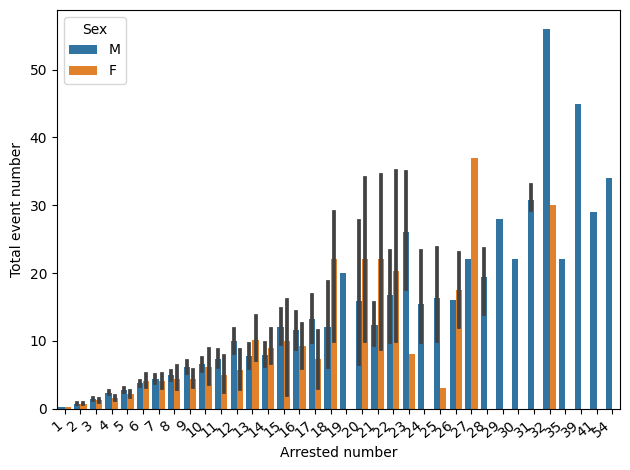

In [ ]:
ax = sns.barplot(data=data, x="Arrested number", y="Total event number", hue="Sex")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
#code for Cohen's D 

#function to calculate the pooled standard deviation of 2 samples
def pooled_standard_deviation(sample1,sample2):
    #calculate the sample size
    n1, n2 = len(sample1), len(sample2)
    #calculate the variances
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    #calculate the pooled standard deviation
    numerator = ((n1-1) * var1) + ((n2-1) * var2)
    denominator = n1+n2-2
    return np.sqrt(numerator/denominator)

# function to calculate Cohen's d for independent samples
def Cohens_d(sample1, sample2):
    u1, u2 = np.mean(sample1), np.mean(sample2)
    s_pooled = pooled_standard_deviation(sample1, sample2)
    #print(s_pooled)
    return ((u1 - u2) / s_pooled)

In [ ]:
#Create gender groups from dataset 
F = data[data['Sex']=='F']
M = data[data['Sex']=='M']

F_Arrested = F['Arrested number']
M_Arrested = M['Arrested number']

In [ ]:
#Conduct power analysis 
from statsmodels.stats.power import TTestIndPower
effect_size = Cohens_d(M_Arrested,F_Arrested)
alpha = 0.05
power = 0.8
ratio_ =len(F_Arrested)/len(M_Arrested)
print('Effect size (Cohen\'s D) for period 3 grades:',effect_size)

Effect size (Cohen's D) for period 3 grades: 0.06852953568200851


In [ ]:
#https://www.statsmodels.org/dev/generated/statsmodels.stats.power.TTestIndPower.solve_power.html
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for M_Arrested') 
print('Actual size of M_Arrested:', len(M_Arrested))
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for F_Arrested')
print('Actual size of F_Arrested:', len(F_Arrested))

Sample Size of nobs1: 8142.368 needed for M_Arrested
Actual size of M_Arrested: 29648
Sample Size of nobs2: 2103.427 needed for F_Arrested
Actual size of F_Arrested: 7659


In [ ]:
#Another way to go about this is the other direction. We can test the power of the actual sample size of the male group
power = TTestPower()
n_test = power.solve_power(nobs=29648, effect_size = effect_size, power = None, alpha = 0.05)
print('Power: {:.3f}'.format(n_test))

Power: 1.000


/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


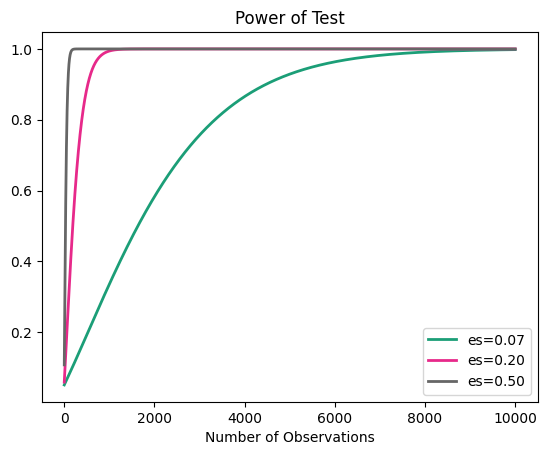

In [ ]:
#Power curve
effect_sizes = np.array([effect_size, 0.2, 0.5])
sample_sizes = np.array(range(5, 10000))
analysis.plot_power(dep_var='nobs', nobs=sample_sizes,
               effect_size=effect_sizes)
plt.show()
     

In [ ]:
#Conduct a T-test to check if the mean arrest times of both genders are equal
t_stat, p_value = ttest_ind(F_Arrested, M_Arrested)
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)

T-statistic value:  -5.346460486332444
P-Value:  9.021713706600806e-08


In [ ]:
#Conduct a T-test to check if the mean event numbers of both genders are equal
t_stat, p_value = ttest_ind(F['Total event number'], M['Total event number'])
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)

T-statistic value:  -5.614490569527928
P-Value:  1.9854137436681365e-08


In [ ]:
#Apply ANCOVA
#Null hypothesis: Arrestees of both genders have same numbers of being arrested on average after accounting for their total event numbers.
ancova(data=data, dv='Arrested number', covar='Total event number', between='Sex')

,Source,SS,DF,F,p-unc,np2
0,Sex,9.743263,1,4.424106,0.035441,0.000119
1,Total event number,69179.972620,1,31412.426274,0.000000,0.457131
2,Residual,82155.057877,37304,NaN,NaN,NaN


# RQ2: Logistic Regression

In [34]:
#Import the following libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.stats.multicomp as mc
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy import stats
from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

import statsmodels.formula.api as smf

from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Read the file
# df = pd.read_csv("Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv")
df = pd.read_csv("/content/drive/MyDrive/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv")
df

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
3,2021,Jan-Mar,1052190,6029059.0,327535,Black,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4
4,2021,Jan-Mar,1015512,6040372.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65271,2021,Oct-Dec,1055609,6044336.0,316123,Indigenous,F,Aged 25 to 34 years,Not a youth,XX,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,65272
65272,2021,Oct-Dec,1032758,6031692.0,307736,South Asian,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65273
65273,2021,Oct-Dec,1021067,6064396.0,324057,White,F,Aged 45 to 54 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65274
65274,2021,Oct-Dec,1008998,6008662.0,331870,Unknown or Legacy,M,Aged 17 years and under,Youth (aged 17 years and under),XX,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,65275


In [5]:
# Having a look at the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65276 entries, 0 to 65275
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Arrest_Year                      65276 non-null  int64  
 1   Arrest_Month                     65276 non-null  object 
 2   EventID                          65276 non-null  int64  
 3   ArrestID                         64807 non-null  float64
 4   PersonID                         65276 non-null  int64  
 5   Perceived_Race                   65272 non-null  object 
 6   Sex                              65276 non-null  object 
 7   Age_group__at_arrest_            65252 non-null  object 
 8   Youth_at_arrest__under_18_years  65276 non-null  object 
 9   ArrestLocDiv                     65276 non-null  object 
 10  StripSearch                      65276 non-null  int64  
 11  Booked                           65276 non-null  int64  
 12  Occurrence_Categor

In [6]:
# Lets see how many missing values we have in our dataset
df.isnull().sum()

Arrest_Year                            0
Arrest_Month                           0
EventID                                0
ArrestID                             469
PersonID                               0
Perceived_Race                         4
Sex                                    0
Age_group__at_arrest_                 24
Youth_at_arrest__under_18_years        0
ArrestLocDiv                           0
StripSearch                            0
Booked                                 0
Occurrence_Category                  165
Actions_at_arrest___Concealed_i        0
Actions_at_arrest___Combative__        0
Actions_at_arrest___Resisted__d        0
Actions_at_arrest___Mental_inst        0
Actions_at_arrest___Assaulted_o        0
Actions_at_arrest___Cooperative        0
SearchReason_CauseInjury           57475
SearchReason_AssistEscape          57475
SearchReason_PossessWeapons        57475
SearchReason_PossessEvidence       57475
ItemsFound                         57475
ObjectId        

In [7]:
# Checking to see how many perceived races are in the dataset
df['Perceived_Race'].value_counts()

White                   27723
Black                   17526
Unknown or Legacy        5056
East/Southeast Asian     4415
South Asian              3613
Middle-Eastern           3237
Indigenous               1934
Latino                   1768
Name: Perceived_Race, dtype: int64

In [8]:
#Trying to fix the Unkown or Legacy values
#First, assigning a null value to them
df['Perceived_Race'] = df['Perceived_Race'].replace('Unknown or Legacy', pd.NA)

In [9]:
df['Perceived_Race'].isnull().sum()

5060

In [10]:
df[['Perceived_Race']]=df.groupby('PersonID')[['Perceived_Race']].fillna(method='ffill')

In [11]:
df = df[df['Perceived_Race'].notna()]
df['Perceived_Race'].isnull().sum()

0

In [12]:
df.drop(df.loc[df['Sex']=='U'].index, inplace=True)

<ipython-input-12-75d8f7d68787>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df.loc[df['Sex']=='U'].index, inplace=True)


In [13]:
#Checking some individual columns and seeing if we can optimize them for analysis
df['Occurrence_Category'].value_counts()

Assault                                            7257
Assault & Other crimes against persons             6728
Robbery & Theft                                    4296
Warrant                                            4165
FTA/FTC/Compliance Check/Parollee                  4147
Police Category - Administrative                   3788
FTA/FTC, Compliance Check & Parollee               3692
Robbery/Theft                                      3561
Drug Related                                       2562
Other Statute & Other Incident Type                2216
Other Offence                                      1855
Vehicle Related (inc. Impaired)                    1775
Mischief & Fraud                                   1558
Mischief                                           1267
Harassment/Threatening                             1248
Impaired                                           1199
Harassment & Threatening                           1180
Weapons                                         

In [14]:
# Lets assign 99999 to missing arrest values and others as 0
df = df.fillna(value = {
    'ArrestID': 99999,
    'SearchReason_CauseInjury': 0,
    'SearchReason_AssistEscape': 0,
    'SearchReason_PossessWeapons': 0,
    'SearchReason_PossessEvidence':0,
    'ItemsFound': 0
    })
df['Occurrence_Category'].fillna(value='Other Offence', inplace=True)
# Renaming values that are similar
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Break and Enter$", "Robbery/Theft", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Break & Enter$", "Robbery/Theft", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Other Statute & Other Incident Type$", "Other Offence", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Other Statute$", "Other Offence", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Harassment/Threatening$", "Harassment & Threatening", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^FTA/FTC, Compliance Check & Parollee$", "Warrant/Police", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^FTA/FTC/Compliance Check/Parollee$", "Warrant/Police", x))

df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Assault & Other crimes against persons$", "Assault", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Robbery & Theft$", "Robbery/Theft", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Mischief$", "Mischief & Fraud", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Fraud$", "Mischief & Fraud", x))

df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Vehicle Related$", "Vehicle Related (inc. Impaired)", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Impaired$", "Vehicle Related (inc. Impaired)", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Homicide$", "Weapons & Homicide", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Weapons$", "Weapons & Homicide", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Crimes against Children$", "Sexual Related Crimes & Crimes Against Children", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Sexual Related Crime$", "Sexual Related Crimes & Crimes Against Children", x))

df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Police Category - Incident$", "Warrant/Police", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Police Category - Administrative$", "Warrant/Police", x))
df["Occurrence_Category"] = df["Occurrence_Category"].apply(lambda x: re.sub("^Warrant$", "Warrant/Police", x))



In [15]:
df['Occurrence_Category'].value_counts()

Warrant/Police                                     16324
Assault                                            13985
Robbery/Theft                                       9586
Other Offence                                       5125
Vehicle Related (inc. Impaired)                     3684
Mischief & Fraud                                    3236
Drug Related                                        2562
Harassment & Threatening                            2428
Weapons & Homicide                                  2136
Sexual Related Crimes & Crimes Against Children     1506
LLA                                                  569
Mental Health                                        233
Name: Occurrence_Category, dtype: int64

In [16]:
df["Perceived_Race"].value_counts()

White                   28182
Black                   17825
East/Southeast Asian     4522
South Asian              3713
Middle-Eastern           3334
Indigenous               1984
Latino                   1814
Name: Perceived_Race, dtype: int64

In [17]:
#From EDA, we saw that the biggest difference is between white and black race, so keeping all other races as "Other"
df["Perceived_Race"] = df["Perceived_Race"].apply(lambda x: re.sub("^East/Southeast Asian$", "AllOthers", x))
df["Perceived_Race"] = df["Perceived_Race"].apply(lambda x: re.sub("^Indigenous$", "AllOthers", x))
df["Perceived_Race"] = df["Perceived_Race"].apply(lambda x: re.sub("^Latino$", "AllOthers", x))
df["Perceived_Race"] = df["Perceived_Race"].apply(lambda x: re.sub("^Middle-Eastern$", "AllOthers", x))
df["Perceived_Race"] = df["Perceived_Race"].apply(lambda x: re.sub("^South Asian$", "AllOthers", x))

In [18]:
#trying to get total arrests as a quantitive feature
# df['PersonID'].value_counts()
dfFeatured2 = df.groupby('PersonID').size().reset_index(name='TotalInteractions')
dfFeatured2.isna().sum()

PersonID             0
TotalInteractions    0
dtype: int64

In [19]:
dfFeatured2

,PersonID,TotalInteractions
0,300000,1
1,300001,1
2,300002,1
3,300003,8
4,300004,1
...,...,...
34505,337342,5
34506,337343,1
34507,337344,1
34508,337345,1


In [20]:
df = pd.merge(df, dfFeatured2, on="PersonID")

<Axes: xlabel='StripSearch', ylabel='Perceived_Race'>

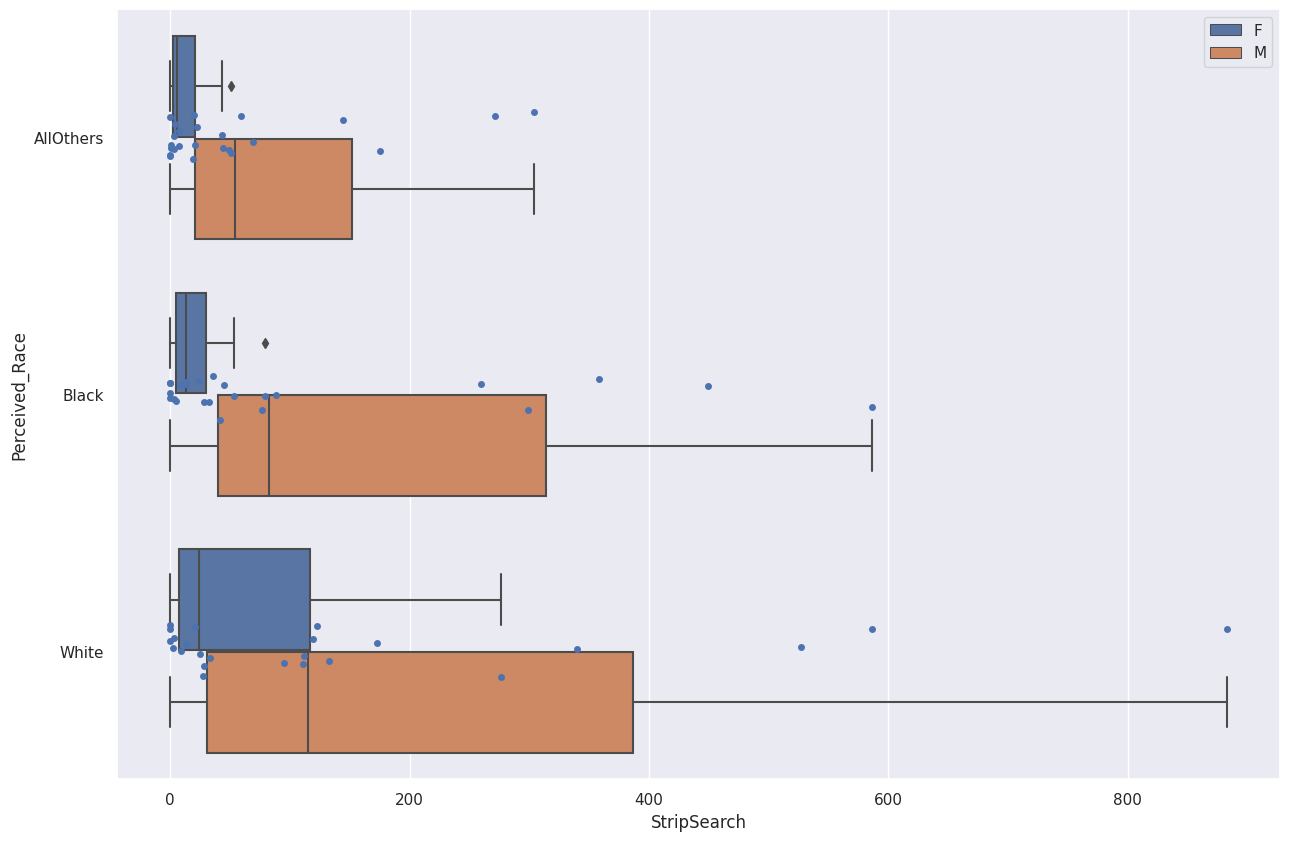

In [21]:
#EDA

stripSearchs = df.groupby(['Perceived_Race','Sex','Occurrence_Category'])['StripSearch'].sum().reset_index()

sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(data=stripSearchs, x="StripSearch", y="Perceived_Race", hue="Sex")
sns.stripplot(x='StripSearch', y='Perceived_Race', data=stripSearchs)

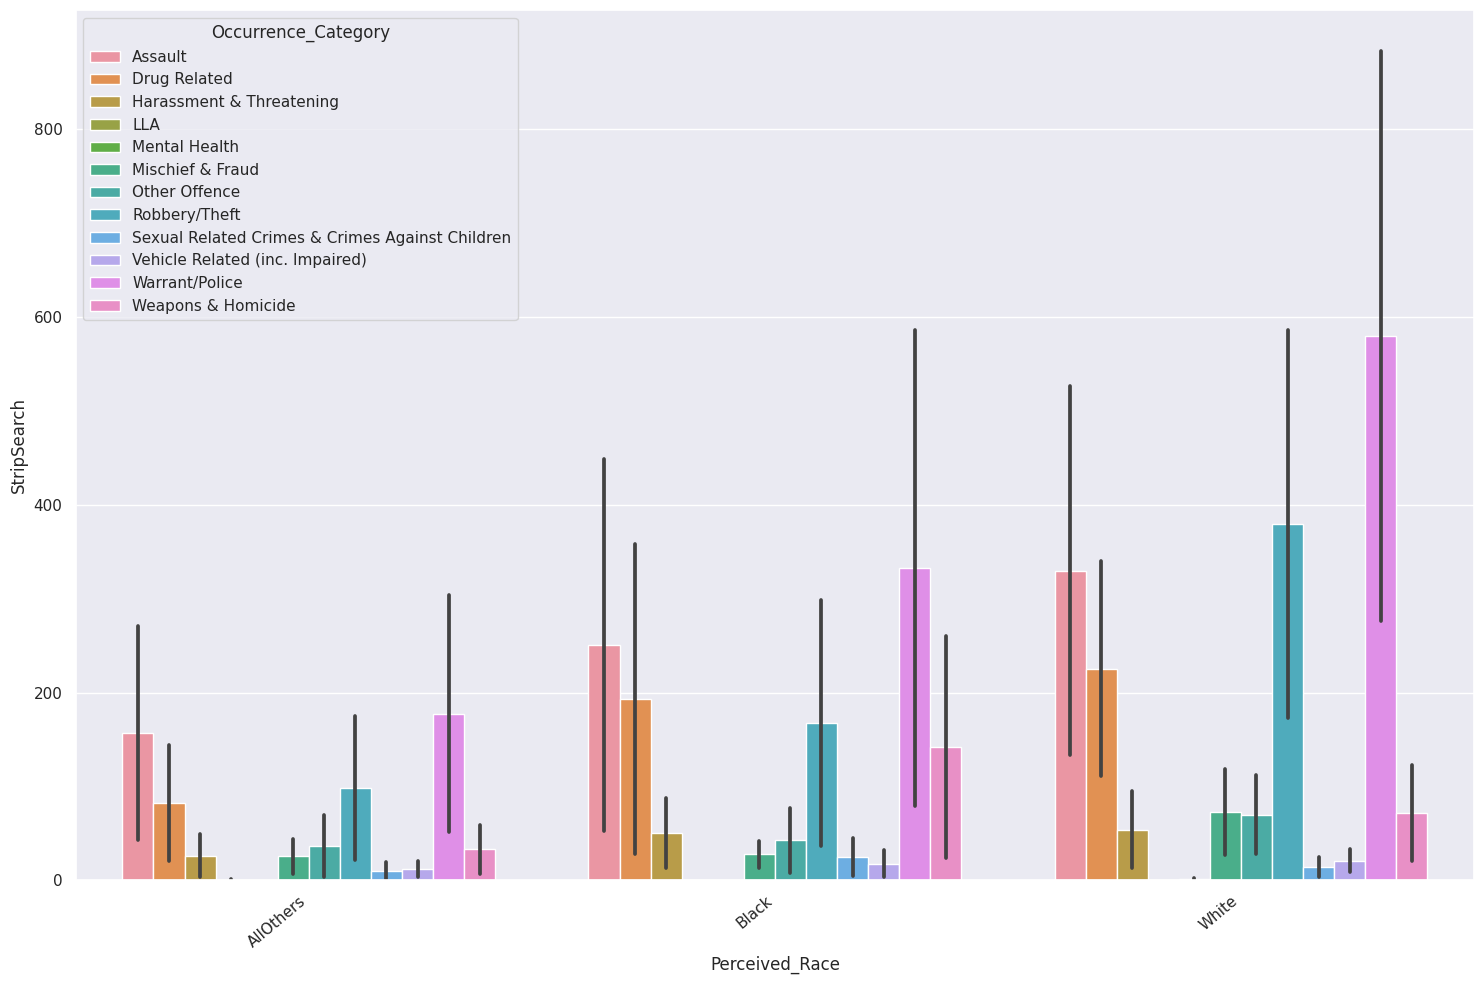

In [22]:
ax = sns.barplot(data=stripSearchs, x="Perceived_Race", y="StripSearch", hue="Occurrence_Category")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [23]:
x = df[['TotalInteractions', 'Perceived_Race', 'Occurrence_Category', 'Sex']].copy()

In [24]:
x  = pd.get_dummies(x, columns = ['Perceived_Race', 'Sex'], drop_first=True)
y = df[['StripSearch']].copy()

In [25]:
y['StripSearch'].value_counts()

0    53920
1     7454
Name: StripSearch, dtype: int64

In [26]:
y['StripSearch']

0        0
1        0
2        0
3        0
4        0
        ..
61369    0
61370    0
61371    0
61372    0
61373    0
Name: StripSearch, Length: 61374, dtype: int64

In [27]:
#Checking the assumptions for Logistic Regression
# Box Tidwell 
dfBT = x
dfBT.head()

,TotalInteractions,Occurrence_Category,Perceived_Race_Black,Perceived_Race_White,Sex_M
0,3,Assault,0,1,1
1,3,Assault,0,1,1
2,3,Assault,0,1,1
3,3,Harassment & Threatening,1,0,1
4,3,Warrant/Police,0,0,1


In [29]:
continuous_var = ['TotalInteractions']
for var in continuous_var:
    dfBT[f'{var}:Log_{var}'] = dfBT[var].apply(lambda x: x * np.log(x)) #np.log = natural log

dfBT.head()

,TotalInteractions,Occurrence_Category,Perceived_Race_Black,Perceived_Race_White,Sex_M,TotalInteractions:Log_TotalInteractions
0,3,Assault,0,1,1,3.295837
1,3,Assault,0,1,1,3.295837
2,3,Assault,0,1,1,3.295837
3,3,Harassment & Threatening,1,0,1,3.295837
4,3,Warrant/Police,0,0,1,3.295837


In [30]:
# Keep columns related to continuous variables
cols_to_keep = continuous_var + dfBT.columns.tolist()[-len(continuous_var):]
cols_to_keep

['TotalInteractions', 'TotalInteractions:Log_TotalInteractions']

In [35]:
X_lt = dfBT[cols_to_keep]
y_lt = y['StripSearch']

# Add constant
X_lt = sm.add_constant(X_lt, prepend=False)
  
# Build model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_lt, X_lt, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

# From this test, not sure if i ran it pefectly or not, from this test, the total interactions are statistically significant and hence non-linear. 

                 Generalized Linear Model Regression Results                  
Dep. Variable:            StripSearch   No. Observations:                61374
Model:                            GLM   Df Residuals:                    61371
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21886.
Date:                Fri, 14 Apr 2023   Deviance:                       43771.
Time:                        14:46:03   Pearson chi2:                 6.07e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02608
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

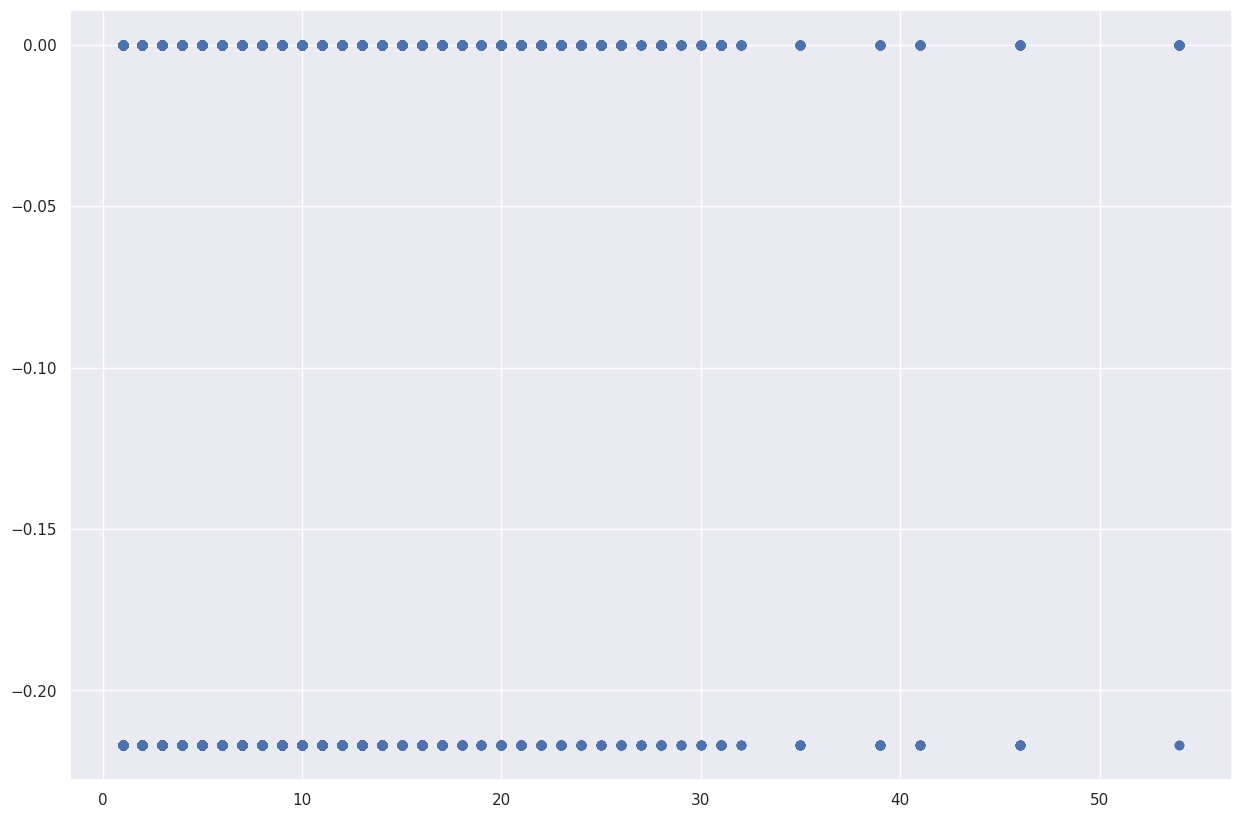

In [39]:
logit_results = GLM(y, x['TotalInteractions'], family=families.Binomial()).fit()
predicted = logit_results.predict(y)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x = x['TotalInteractions'].values, y = log_odds);
plt.show()

In [ ]:
#Split train and test data
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state=123) 

In [ ]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46030 entries, 14670 to 52734
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   StripSearch  46030 non-null  int64
dtypes: int64(1)
memory usage: 719.2 KB


In [ ]:
# Create the formula string 
all_columns = ' + '.join(x)
formula = "StripSearch ~ " + all_columns 
print("Formula: ", formula, "\n")

Formula:  StripSearch ~ TotalInteractions + Occurrence_Category + Perceived_Race_Black + Perceived_Race_White + Sex_M 



In [ ]:
trainingdata = pd.concat([x_train,y_train], axis = 1)
log_reg_1 = smf.logit(formula, data=trainingdata).fit()
log_reg_1.summary()

         Current function value: 0.343411
         Iterations: 35


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            StripSearch   No. Observations:                46030
Model:                          Logit   Df Residuals:                    46014
Method:                           MLE   Df Model:                           15
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                 0.07530
Time:                        22:48:26   Log-Likelihood:                -15807.
converged:                      False   LL-Null:                       -17094.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 -2.8413      0.055    -51.383      0.000      -2.950      -2.733
Occurrence_Category[T.Drug Related]                                        1.6401      0.057     28.535      0.000       1.527       1.753
Occurrence_Category[T.Harassment & Threatening]                            0.0212      0.082      0.257      0.797      -0.140       0.183
Occurrence_Category[T.LLA]                                               -16.8689    519.328     -0.032      0.974   -1034.733    1000.995
Occurrence_Category[T.Mental Health]                                      -3.1575      1.004     -3.144      0.002      -5.126      -1.189
Occurrence_Category[T.Mischief & Fraud]                                   -0.3824      0.081     -4.716      0.000      -0.541      -0.224
Occurrence_Category[T.Other Offence]                                      -0.7634      0.077     -9.873      0.000      -0.915      -0.612
Occurrence_Category[T.Robbery/Theft]                                       0.1164      0.048      2.416      0.016       0.022       0.211
Occurrence_Category[T.Sexual Related Crimes & Crimes Against Children]    -0.4538      0.124     -3.648      0.000      -0.698      -0.210
Occurrence_Category[T.Vehicle Related (inc. Impaired)]                    -1.2295      0.117    -10.521      0.000      -1.459      -1.000
Occurrence_Category[T.Warrant/Police]                                      0.1136      0.042      2.692      0.007       0.031       0.196
Occurrence_Category[T.Weapons & Homicide]                                  0.9775      0.068     14.452      0.000       0.845       1.110
TotalInteractions                                                          0.0586      0.002     26.706      0.000       0.054       0.063
Perceived_Race_Black                                                       0.4230      0.043      9.846      0.000       0.339       0.507
Perceived_Race_White                                                       0.3911      0.040      9.706      0.000       0.312       0.470
Sex_M                                                                      0.2224      0.039      5.657      0.000       0.145       0.300
==========================================================================================================================================
"""

In [ ]:
pred_1 = log_reg_1.predict(x_test)
prediction_1 = list(map(round, pred_1))
# Accuracy score
print('\nTest accuracy = ', accuracy_score(y_test, prediction_1))


Test accuracy =  0.8797575599582899


In [ ]:
# Confusion matrix
cm2 = confusion_matrix(y_test, prediction_1)
print ("\nConfusion Matrix : \n", cm2) 


Confusion Matrix : 
 [[13482    35]
 [ 1810    17]]


In [ ]:
np.exp(log_reg_1.params)

Intercept                                                                 5.834726e-02
Occurrence_Category[T.Drug Related]                                       5.155551e+00
Occurrence_Category[T.Harassment & Threatening]                           1.021389e+00
Occurrence_Category[T.LLA]                                                4.719651e-08
Occurrence_Category[T.Mental Health]                                      4.253108e-02
Occurrence_Category[T.Mischief & Fraud]                                   6.821966e-01
Occurrence_Category[T.Other Offence]                                      4.660909e-01
Occurrence_Category[T.Robbery/Theft]                                      1.123390e+00
Occurrence_Category[T.Sexual Related Crimes & Crimes Against Children]    6.351833e-01
Occurrence_Category[T.Vehicle Related (inc. Impaired)]                    2.924293e-01
Occurrence_Category[T.Warrant/Police]                                     1.120284e+00
Occurrence_Category[T.Weapons & Homicide]  

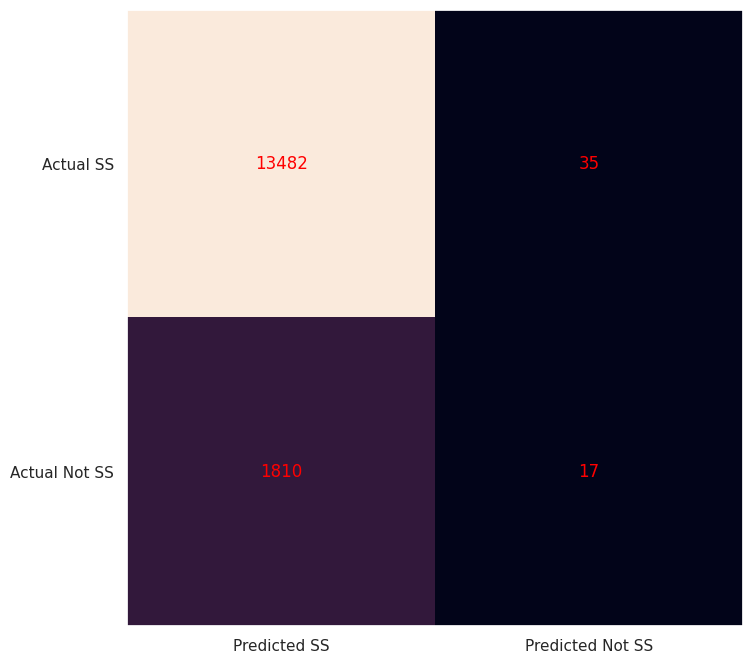

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm2)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted SS', 'Predicted Not SS'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual SS', 'Actual Not SS'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm2[i, j], ha='center', va='center', color='red')
plt.show()